In [60]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
import networkx as nx
from munkres import Munkres
from numpy import linalg as LA
from sklearn.cluster import KMeans
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
from scipy.stats import bernoulli

# **NETWORK GENERATION**

In [61]:
def network_generate():
        ### We may have real world networks or synthetic graphs following the DCSBM

    ## Choice of the network to generate
    #network='real_world'   ## Choose either 'real_world' or 'real_world'
    network='DCSBM'

    if network=='real_world':
        ##Get the adjacency matrix
        #Given the network, find the corresponding adjacency matrix
        scenario='dolphins.gml'
        G = nx.read_gml(scenario)
        G_0=G

        ##Remove nodes without neighbors
        isolated_nodes=nx.isolates(G)
        G.remove_nodes_from(isolated_nodes)

        ## Adjacency matrix
        A=nx.adjacency_matrix(G,nodelist=None,weight=None)
        A=A.todense()

        ##New number of instances after removing isolated nodes
        n=len(A[:,1])

        ## Ground truth
        ground_truth=np.zeros((n,1))
        for i in range(int(0),int(n)):
            if(0 in G_0.nodes()):
                ground_truth[i] = G_0.node[i]['value']
            else:
                ground_truth[i] = G_0.node[i+1]['value']

        ## Remove the label of the node with no neighbor
        np.delete(ground_truth,isolated_nodes)
        ##Check wether the first element of the ground truth start from 0 or from 1
        if(min(ground_truth)==0):
            startGround_truth=0
        else:
            startGround_truth = 1

    if network=='DCSBM':
        n_init=2000
        ##Class proportions
        cs = [0.25,0.25,0.5]
        ## Number of classes
        K = len(cs)
        ## Number of instances per class
        ns =np.array(cs) * n_init

        ##Setting of the model parameters
        ## Average connectivities q's
        #bs = [0.25,0.75]
        bs = [0.75, 0.25]
        q1 = 0.4
        q2= 0.8
        q=np.repeat(np.array([q1,q2]),[int(n_init*bs[0]),int(n_init*bs[1])])

        # Choice of affinity matrix M
        #M = 10 * (-1 * np.ones(K) + 2 * np.identity(K))
        M=15*np.identity(K)
        # Construction of C
        C = np.ones((int(K),int(K)))+M/math.sqrt(n_init)

        ##Extenxion of C in an nxn bloc matrix
        large_C=np.zeros((int(n_init),int(n_init)))
        for i in range(int(0),int(K)):
            for j in range(int(0),int(K)):
                large_C[int(np.sum(ns[int(0):i])):int(np.sum(ns[int(0):i+1])),int(np.sum(ns[int(0):j])):int(np.sum(ns[int(0):j+1]))]=C[i,j]*np.ones((ns[i],ns[j]))

        ## Construction of matrix of DCSBM edge probabilities
        P=np.minimum(((np.diag(q)).dot(large_C)).dot(np.diag(q)),np.ones((n_init,n_init)))
        ## Generation adjacency matrix A
        A = np.zeros((int(n_init), int(n_init)))
        for i in range(int(0),int(n_init)):
            #A[i,]=np.random.binomial(1,P[i,], size=n)
            A[i,]=bernoulli.rvs(P[i,:],size=n_init)

        ## Ground_truth
        ground_truth = np.zeros((n_init,1))
        for i in range(int(0),int(K)):
            ground_truth[int(np.sum(ns[int(0):i])):int(np.sum(ns[int(0):i+1]))]=i* np.ones((ns[i],1))

        ##Construct graph from adjacency matrix
        G = nx.from_numpy_matrix(A)
        ##Remove nodes without neighbors
        isolated_nodes=nx.isolates(G)
        G.remove_nodes_from(isolated_nodes)
        ## Remove the label of the node with no neighbor
        np.delete(ground_truth,isolated_nodes)

        A=nx.adjacency_matrix(G,nodelist=None,weight=None)
        A=A.todense()

        ## Symmetrization of the adjacency matrix in order to have an undirected unweighted graph
        A = np.triu(A)+np.transpose(np.triu(A))
        startGround_truth=0

    return A,ground_truth,startGround_truth

# **OPTIMAL ALPHA ESTIMATE**

In [62]:
def optimal_alpha(qEst,n):

    alpha = np.arange(0, 1, 0.01)
    limit = []
    for a in alpha:
        left = 0.0
        right = 100.0

        found_a_valid_point = 0

        gsavetmp = 0
        gsave = 1
        val_external_watchdog = 1000
        external_watchdog = 1

        q_pow_1m2a = np.power(qEst, (1 - 2 * a))
        q_pow_2m2a = np.power(qEst, (2 - 2 * a))

        while (abs(gsavetmp - gsave) > 1e-5 and external_watchdog < val_external_watchdog):
            x = (left + right) / 2
            watchdog = 1
            ftmp = 0
            gtmp = 0
            f = 1
            g = 1

            while (max([abs(gtmp - g), abs(ftmp - f)]) > 1e-10 and watchdog < 1e2):
                ftmp = f
                gtmp= g

                den=(1./n)/(-x - q_pow_1m2a * ftmp + q_pow_2m2a * gtmp)
                f = np.dot(np.squeeze(np.asarray(q_pow_1m2a)),np.squeeze(np.asarray(den)))

                g = np.dot(np.squeeze(np.asarray(q_pow_2m2a)),np.squeeze(np.asarray(den)))

                watchdog = watchdog + 1

            if (watchdog < 1e2):
                found_a_valid_point = 1
                gsavetmp = gsave
                right = x
                gsave = g
            else:
                if (found_a_valid_point == 0):
                    right = 2 * right
                left = x
            external_watchdog += 1

        g = gsave

        limit.append(-1.0 / g)


    # plot(alpha,limit)
    min_value = min(limit)
    index = np.where(limit == min_value)[0]
    alpha = alpha[index]

    return alpha

# **REGULARIZED LEADING EIGENVECTORS**

In [63]:
def regularized_eigenvectors(A, d, K, alpha):
    d = np.array(d)
    n = len(A[:, 1])
    # Compute the degrees and other related metrics
    dalpha = np.power(d, -alpha)

    d1alpha = np.power(d, (alpha - 1))
    invDalpha = np.diag(dalpha[:, 0])
    invD1alpha = np.diag(d1alpha[:, 0])


    # Compute the affinity matrix L_alpha
    B = (A - d.dot(np.transpose(d)) / (np.transpose(d).dot((np.ones((n, 1)))))) / math.sqrt(n)
    L_alpha = (invDalpha.dot(B)).dot(invDalpha)

    # Compute the dominant eigenvectors of L_alpha
    evals_large_sparse, evecs_large_sparse = largest_eigsh(L_alpha, K-1, which='LM')

    #Normalize the dominant eigenvectors
    normalized_evecs = invD1alpha.dot(evecs_large_sparse)

    return normalized_evecs,L_alpha



# **K-MEANS AND PERFORMANCE EVALUATION**

In [64]:
def modified_kmeans(normalized_evecs, K, ground_truth, startGround_truth):
    
    ## Number of instances
    n=len(ground_truth)

    ## k-means to normalized eigenvectors
    kmeans_output = KMeans(n_clusters=K, init='k-means++', random_state=None).fit(normalized_evecs)
    labels = kmeans_output.labels_

    #print labels



    ## Computation of the cost matrix
    costMat = np.zeros((int(K), int(K)))
    for a in range(int(0), int(K)):
        for b in range(int(0), int(K)):
            idd = np.where(labels == a)[0]
            if (startGround_truth == 0):
                costMat[a, b] = -(np.sum((np.array(ground_truth))[idd] == b)) ** 2
            else:
                costMat[a, b] = -(np.sum((np.array(ground_truth))[idd] == (b + 1))) ** 2
    #print costMat

    ## Find the best label permutation best matching the ground truth with the previous cost Matrix using the Hungarian Munkres algorithm
    m = Munkres()
    permutation = m.compute(costMat)
    #print  permutation
    perm = np.array(permutation)

    ## Permute the labels
    Labels = []
    for l in range(int(0), int(n)):
        for j in range(int(0), int(K)):
            if labels[l] == j:
                Labels.append(perm[j, 1])

    # Labels = np.transpose(labels)

    ## Compute the accuracy (normalized number of matching with the ground truth)
    if (startGround_truth == 0):
        accuracy = float(np.sum(((np.asarray(Labels)) == np.squeeze(ground_truth)))) / n
    else:
        accuracy = float(np.sum(((np.asarray(Labels) + 1) == np.squeeze(ground_truth)))) / n

    ## Compute the overlap performance
    perf = (accuracy - 1.0 / K) / (1 - 1.0 / K)
    print("The overlap performance for this graph is:",perf)

    return perf



# **HISTOGRAM OF THE EIGENVALUES**

In [65]:
def histogram_eigenvalues(matrix,qEst,alpha):

    ##Computation of the similarity matrix length
    n=len(matrix[:,0])

    ## Eigenvalues of the similarity matrix
    evals, evecs=LA.eig(matrix)

    ## Histogram of eigenvalues
    n_bins=100
    N, bins, patches = plt.hist(evals, n_bins, normed=1, facecolor='red')


    ## Limiting spectrum (Theory)
    limit_spectrum = np.zeros((len(bins), 1))

    j = 0
    for x in bins:
        ## The density (at x) of a given measure \mu having Stieljes transform m is given by \mu(x)= imaginary_part(m(z))
        ## for z=x+e*1j in the limit when e-->0. This is what is implementing in the following. The Stieltjes transform
        ##for our model is E which is a function of f,g and of the average connectivities qEst. f,g are defined through a
        ##system of fixed point equations computed by the function that we call Stieltjes. The details are given in our
        ##article http://laneas.com/sites/default/files/attachments-16202/JMLR_format_CD_0.pdf
        z = x + (10 ** (-2))*1j
        [f, g] = Stieltjes(qEst, n, z, alpha, 1e3)
        E = (np.sum(1. / (-z - f * np.power(qEst, (1 - 2 * alpha)) + g * np.power(qEst, (2 - 2 * alpha)))))/n
        limit_spectrum[j] = (1. / math.pi) * E.imag
        j+=1
    
    print("This is a visualization of the empirical density of the eigenvalues of the graph similarity matrix along with the theoretical density")
    plt.plot(bins,limit_spectrum)
    plt.show()

# **COMPUTATION OF THE STIELTJES TRANSFORM OF THE MODEL**

In [66]:
### This function is a simple implementation of the solution of the fixed points equations defined in the Theorem 3
### of our article http://laneas.com/sites/default/files/attachments-16202/JMLR_format_CD_0.pdf

### Input: qEst: the estimated average connectivities weights,
### n: length of the average connectivities or number of graph nodes,
### z: complex number at which we want to evaluate the model Stieltjes transform
### alpha: degree power parameter for the normalization of the modularity matrix
### val_watchdog: stopping number of iterations for the algorithm

### Output: f(z),g(z) parameters allowing to compute the model Stieltjes transform at z

def Stieltjes(qEst, n, z, alpha, val_watchdog):

    q_pow_1m2a = np.power(qEst, (1 - 2 * alpha))
    q_pow_2m2a = np.power(qEst, (2 - 2 * alpha))
    ftmp = 0
    gtmp = 0
    f = 1
    g = 1

    watchdog=1
    while (max([abs(gtmp - g), abs(ftmp - f)]) > 1e-10 and watchdog < val_watchdog):
        ftmp = f
        gtmp = g

        den = (1. / n) / (-z - q_pow_1m2a * ftmp + q_pow_2m2a * gtmp)
        f = np.dot(np.squeeze(np.asarray(q_pow_1m2a)), np.squeeze(np.asarray(den)))
        g = np.dot(np.squeeze(np.asarray(q_pow_2m2a)), np.squeeze(np.asarray(den)))

        watchdog = watchdog + 1

    return f,g

# **VISUALIZATION OF LEADING EIGENVECTORS USED FOR CLUSTERING**

In [67]:
def eigen_plots(L_alpha,number_of_dominant_vectors_to_extract):
    # Compute the dominant eigenvectors of L_alpha
    evals_large_sparse, evecs_large_sparse = largest_eigsh(L_alpha, number_of_dominant_vectors_to_extract, which='LM')
    plt.plot(evecs_large_sparse[:,-1],evecs_large_sparse[:,-2],'*', color='red')
    
    print("The following plot is a representation in 2D of the two dominant eigenvectors of the graph similarity matrix")
    plt.show()

# **MAIN**

/Users/hafiztiomokoali/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


The overlap performance for this graph is: 0.9947499999999999
This is a visualization of the empirical density of the eigenvalues of the graph similarity matrix along with the theoretical density


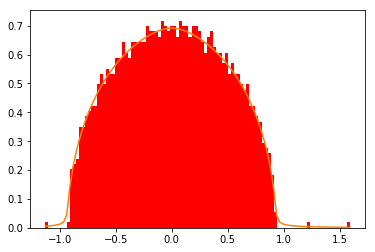

The following plot is a representation in 2D of the two dominant eigenvectors of the graph similarity matrix


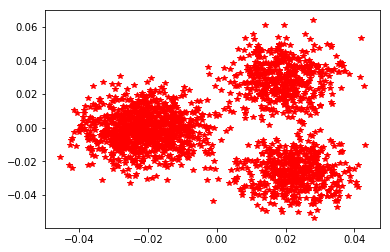

In [68]:
### Get the graph on which we want to extract the communities
A, ground_truth, startGround_truth = network_generate()  ## startGround_truth is 0 when the minimum value of the ground truth is 0 and 1 otherwise
### Get the adjacency matrix and the ground_truth from csv files
#A = np.genfromtxt('adjacency.csv', delimiter=",")
#ground_truth = np.genfromtxt('conf_true.csv', delimiter=",")

n=len(A[:,1])

## Step 1: Compute the optimal value of \alpha

#### The following part is concerned by the estimation of the model parameters given the adjacency matrix
## Degree vector
d = A.dot(np.ones((n, 1)))

##Estimate the average connectivities
qEst = d / math.sqrt(np.sum(d))

## Number of classes
if (startGround_truth == 0):
    K = int(np.amax(ground_truth) + 1)
else:
    K = int(np.amax(ground_truth))
#print K

alpha=optimal_alpha(qEst,n)
alpha=0
#print alpha


#### Step 2: Leading eigenvectors of L_alpha extraction
normalized_evecs,L_alpha=regularized_eigenvectors(A, d, K, alpha)


### Step 3: Kmeans on the normalized eigenvectors and computation of performances
perf = modified_kmeans(normalized_evecs, K, ground_truth, startGround_truth)

## Histogram of the eigenvalues (Empirical vs Theory)

histogram_eigenvalues(L_alpha,qEst,alpha)


### Plot of the eigenvectors in 2D
eigen_plots(L_alpha,4)

